In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0627 23:19:40.877109 4544058816 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 8
n_test = 10000

x_train = np.linspace(-1, 1-2/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-2/n_test, n_test).astype(np.float64)

x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Train neural network

In [9]:
#Configurations
eps_train = 0.05                                                                                                                            
eps_test = 0.05
pgd_eta, pgd_num_iter = 1e-3, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (1,)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 100, 0.00, 3e-4, 8 # Will have to experiment with learning rate a bit.                                                                                              


In [10]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 32]
dataset = ((x_train, y_train), (x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        preds_list = model.pgd_fit(sess, x_train, y_train, eps_train, pgd_eta, pgd_num_iter, training_epochs = epochs, lr = lr, batch_size = batch_size, x_test = x_test)
        
        cross_loss, cross_acc = model.evaluate(sess, x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0627 23:19:41.392331 4544058816 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0627 23:19:41.393739 4544058816 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0627 23:19:41.400143 4544058816 feedforward_robust.py:40] Created placeholders for x and y
W0627 23:19:41.401928 4544058816 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0627 23:19:41.402838 4544058816 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0627 23:19:41.403945 4544058816 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0627 23:19:41.853273 4544058816 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.806995630 
I0627 23:19:42.397699 4544058816 feedforward_robust.py:884] Epoch: 0001    cost: 0.806995630 
Accuracy on batch: 0.875000
I0627 23:19:42.399362 4544058816 feedforward_robust.py:885] Accuracy on batch: 0.875000
Epoch: 0002    cost: 0.803573608 
I0627 23:19:42.505391 4544058816 feedforward_robust.py:884] Epoch: 0002    cost: 0.803573608 
Accuracy on batch: 0.875000
I0627 23:19:42.506725 4544058816 feedforward_robust.py:885] Accuracy on batch: 0.875000
Epoch: 0003    cost: 0.800086141 
I0627 23:19:42.607347 4544058816 feedforward_robust.py:884] Epoch: 0003    cost: 0.800086141 
Accuracy on batch: 0.875000
I0627 23:19:42.608521 4544058816 fe

Accuracy on batch: 1.000000
I0627 23:19:45.520719 4544058816 feedforward_robust.py:885] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.694262862 
I0627 23:19:45.607887 4544058816 feedforward_robust.py:884] Epoch: 0034    cost: 0.694262862 
Accuracy on batch: 0.875000
I0627 23:19:45.609498 4544058816 feedforward_robust.py:885] Accuracy on batch: 0.875000
Epoch: 0035    cost: 0.691190481 
I0627 23:19:45.692533 4544058816 feedforward_robust.py:884] Epoch: 0035    cost: 0.691190481 
Accuracy on batch: 0.875000
I0627 23:19:45.694067 4544058816 feedforward_robust.py:885] Accuracy on batch: 0.875000
Epoch: 0036    cost: 0.682929218 
I0627 23:19:45.771545 4544058816 feedforward_robust.py:884] Epoch: 0036    cost: 0.682929218 
Accuracy on batch: 1.000000
I0627 23:19:45.773046 4544058816 feedforward_robust.py:885] Accuracy on batch: 1.000000
Epoch: 0037    cost: 0.681659937 
I0627 23:19:45.856097 4544058816 feedforward_robust.py:884] Epoch: 0037    cost: 0.681659937 
Accuracy on batch: 1.000

I0627 23:19:48.413947 4544058816 feedforward_robust.py:884] Epoch: 0067    cost: 0.556558490 
Accuracy on batch: 1.000000
I0627 23:19:48.415395 4544058816 feedforward_robust.py:885] Accuracy on batch: 1.000000
Epoch: 0068    cost: 0.563459635 
I0627 23:19:48.498666 4544058816 feedforward_robust.py:884] Epoch: 0068    cost: 0.563459635 
Accuracy on batch: 1.000000
I0627 23:19:48.499919 4544058816 feedforward_robust.py:885] Accuracy on batch: 1.000000
Epoch: 0069    cost: 0.558043540 
I0627 23:19:48.583183 4544058816 feedforward_robust.py:884] Epoch: 0069    cost: 0.558043540 
Accuracy on batch: 1.000000
I0627 23:19:48.584679 4544058816 feedforward_robust.py:885] Accuracy on batch: 1.000000
Epoch: 0070    cost: 0.549205363 
I0627 23:19:48.665212 4544058816 feedforward_robust.py:884] Epoch: 0070    cost: 0.549205363 
Accuracy on batch: 1.000000
I0627 23:19:48.666482 4544058816 feedforward_robust.py:885] Accuracy on batch: 1.000000
Epoch: 0071    cost: 0.554876626 
I0627 23:19:48.749148 45

Optimization Finished!
I0627 23:19:51.191627 4544058816 feedforward_robust.py:886] Optimization Finished!
Final Train Loss 0.273602
I0627 23:19:51.225061 4544058816 feedforward_robust.py:894] Final Train Loss 0.273602
Final Train Accuracy 1.000000:
I0627 23:19:51.226515 4544058816 feedforward_robust.py:895] Final Train Accuracy 1.000000:
Model was evaluated on benign data
I0627 23:19:51.233026 4544058816 feedforward_robust.py:662] Model was evaluated on benign data


----Regular loss and accuracy ----
(0.2862184, 0.9592)


In [11]:
preds_list = np.array(preds_list)

In [12]:
preds_list.shape

(100, 10000, 2)

In [13]:
preds_list[-1]

array([[ 0.7640499 , -1.0708977 ],
       [ 0.7639263 , -1.0707206 ],
       [ 0.76380277, -1.0705433 ],
       ...,
       [-1.5219764 ,  0.803022  ],
       [-1.5221951 ,  0.80313253],
       [-1.5224136 ,  0.80324304]], dtype=float32)

# Processing learned func and plotting

In [14]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [15]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [16]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(100, 10000)

In [17]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(100,)

In [18]:
preds_means

array([0.04292129, 0.05089511, 0.05871561, 0.06643735, 0.07406236,
       0.08164798, 0.08914753, 0.09664769, 0.10433348, 0.11219879,
       0.1201096 , 0.12807259, 0.13603623, 0.14404115, 0.15205447,
       0.16011983, 0.16828234, 0.17639501, 0.18445505, 0.19245765,
       0.20041467, 0.20837109, 0.21639599, 0.22449476, 0.2327218 ,
       0.2411423 , 0.24972813, 0.2583993 , 0.2671798 , 0.2760212 ,
       0.2849485 , 0.29396492, 0.3030814 , 0.31225723, 0.321427  ,
       0.33052194, 0.33969513, 0.3490252 , 0.35847762, 0.36803344,
       0.37770817, 0.38749692, 0.39739472, 0.40741023, 0.4175338 ,
       0.42782813, 0.43825057, 0.4487909 , 0.4594624 , 0.47027862,
       0.48122948, 0.49235135, 0.50362456, 0.51510173, 0.5267689 ,
       0.5385845 , 0.5505818 , 0.56275743, 0.5751042 , 0.5876717 ,
       0.60041064, 0.61333275, 0.62647706, 0.63980633, 0.6533737 ,
       0.66712123, 0.68107706, 0.695163  , 0.70939094, 0.7238015 ,
       0.73835135, 0.7530839 , 0.76804924, 0.78324497, 0.79872

In [19]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [20]:
indices = np.arange(0, 100, 20)
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(5, 10000)

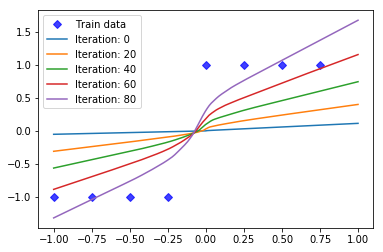

In [21]:
plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)

plt.legend()